# Guía 4 - Modelos estocásticos básicos

## Algunas consideraciones

* Si el modelo encierra la mayoría de los atributos determinísticos de la serie temporal (TS), entonces la serie de los residuos debería verse como una realización de una variable aleatoria independiente.
* Si permanece cierta estructura residual, entonces esta información podría aprovecharse para mejorar los modelos.
* Si esperamos que la serie de los residuos sea una realización de una variable aleatoria independiente, entonces parece natural construir modelos sobre variaciones aleatorias independientes (*white noise o ruido blanco*).

*Asumimos que la serie de los residuos es estacionaria (si no, los coeficientes de los modelos cambiarían).*

## Ruido blanco

Una TS $\{w_t\}$ es un ruido blanco si las variables $w_1, \ldots, w_N$ son independientes e idénticamente distribuídas (iid) con media nula ($\mu=0$) y la autocovarianza cumple

$$\mathrm{Cov}(w_t, w_{t+k}) = \left\{ 
\begin{array}{ll}
\sigma^2 & k=0\,  \mathrm{todo}\,  t \\
0        & k \ne 0 
\end{array}
\right.$$

Además, si las variables siguen una distribución normal se dice que es un ruido blanco gaussiano. Más aú, las propiedades estacionarias de segundo orden son una consecuencia inmediata de la definición (ni la media $\mu$, la varianza $\mathrm{Var}(w_t)=\mathrm{Cov}(w_t, w_t) = \mathrm{Cov}(0)=\sigma^2$ o las distntas autocovarianzas $\mathrm{Cov}_w(k)=0$ dependen de $t$). 


## Ejercicios

1. Generar una serie sintética de ruido blanco. Notar que la biblioteca `numpy` aconseja instanciar `random.Generator.normal` en lugar del antiguo comando `random.normal`. Los generadores de números pseudo-aleatorios (PRNG), típicamente, con una distribución uniforme entre 0 y 1 son la base para obtener, mediante diferentes transformaciones, series que siguen diferentes distribuciones. Las buenas propiedades de los PNRG son centrales para simular TS (ver, por ejemplo, el capítulo 7 de [Numerical Recipes](https://numerical.recipes/book.html))  
    a. Representar la función de acf.  
    b. Observar que un 5% de las autocorrelaciones resultan significativamente distintas de cero. Chequear que esta observación es compatible con el 5% de significancia estadística. ¿Cómo cambiaría si se elige un umbral de 1% de significancia estadística?  
2. Examinar la serie de registros meteorológicos de la estación castelar. Mostar que las series anualizadas de `precip`, `tempmax` y `tempmin` pueden ser compatibles con un ruido blanco.  
    a. Hallar la tendencia con una regresión lineal y mostrar que la temperatura máxima (media anual) aumentaría cerca de una décima de grado por década. ¿Qué confianza se puede asignar a esta estimación? ¿Se puede rechazar la hipótesis nula (que la temperatura no aumenta con el tiempo)?  
    b. Probar que las series anualizadas son estacionarias.  
    c. Representar las autocorrelaciones.  
    d. ¿Se pueden realizar otros tests que muestren que las TS (removiendo la media) son compatibles con realizaciones de una variable aleatoria e independiente?  
  
  




### Ayudas para el ejercicio 2

Comenzamos importando, como es habitual, las bibliotecas de `numpy`, `pandas` y de gráficos `matplotlib`. Además, definimos una función que ayuda en la lectura e intepretación de la prueba de DIckey-Fuller aumentada.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

Cargamos los datos de la estación castelar que almacena los registros a paso diario desde 1970 para la precipitación acumulada en 24 horas, la temperatura máxima y la temperatura mínima diaria. Luego, empleamos el método `resample()` para obtener las medias anuales en los casos de temperatura, y el acumulado anual de lluvias.

Number of rows with missing values: 68


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

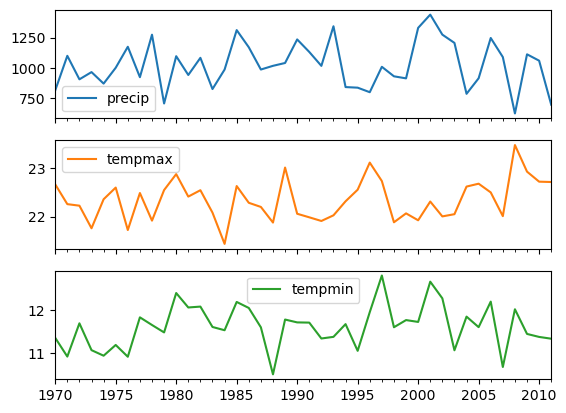

In [29]:
castelar = pd.read_csv('Data/castelar_1970_2011.csv')
castelar.columns = castelar.columns.str.strip()
date_string = castelar['Year'].astype(str) + '-' + castelar['Month'].astype(str) + '-' + castelar['Day'].astype(str)
castelar.set_index(pd.to_datetime(date_string, format='%Y-%m-%d'), inplace=True)
castelar.asfreq('D')
castelar.drop(columns=['Year','Month','Day'], inplace=True)
castelar.replace(-1000, np.nan, inplace=True)
print(f'Number of rows with missing values: {castelar.isnull().any(axis=1).sum()}')
castelar_anual = castelar.resample('1YE').agg({'precip':'sum', 'tempmax':'mean', 'tempmin':'mean'}).asfreq('YE')
castelar_anual.plot(subplots=True)



Finalmente, dejamos el cálculo para obtener la tendencia y el análisis para la hipótesis nula.

In [30]:
from scipy import stats
# Extraemos los días que pasaron desde el inicio de la serie para cada lectura. Luego, removemos la tendencia
interval = np.float32((castelar_anual.index - castelar_anual.index[0]).days.values)/365.2425
res = stats.linregress(interval, castelar_anual['tempmax'])
print(f'Intercept: {res.intercept:.2f}°C')

# Two-sided inverse Students t-distribution
# p - probability, df - degrees of freedom
import scipy.stats as sstats
tinv = lambda p, df: abs(sstats.t.ppf(p/2, df))
ts = tinv(0.05, len(interval)-2)
print(f"slope (95%): ({res.slope:.3f} +/- {ts*res.stderr:.3f})°C/año")


Intercept: 22.17°C
slope (95%): (0.009 +/- 0.011)°C/año


## Notación: Operador de retroceso en el tiempo

El *backward shift* u operador de traslación en reversa en el tiempo se define como

$$\mathbf{B} x_t = X_{t-1}$$

y su aplicación reiterada $n$ veces es

$$\mathbf{B}^n x_t = X_{t-n}$$

## Modelos autoregresivos

La serie $\{x_t\}$ es un proceso autoregresivo de orden AR(p) si 

$$x_t = \alpha_1 x_{t-1} + \cdots + \alpha_p x_{t-p} + w_t$$

donde  $\{w_t\}$ es un ruido blanco, $\alpha_i$ son los parámetros del modelo y $\alpha_p$ debe ser distinto de cero.

Aplicando el opoerador de traslación temporal el modelo AR(p) puede expresarse de manera compacta como un polinomio $\Theta$ en el operador $\matbf{B}$

$$\Theta (\mathbf{B}) x_t = 1 - \alpha_1 x_{t-1} - \cdots - \alpha_p x_{t-p} = w_t$$


### Características


a. El *random walk o camino aleatorio* es un caso especial de AR(1) con $\alpha_1=1$ de manera que resulta

$$x_t = x_{t-1} + w_t$$

b. El *exponential moving average o suavizado exponencial* es un caso especial con $\alpha_i = \alpha(1-\alpha)^i$ para $i=1,2,\ldots,p\rightarrow\infty$

$$u_t = \alpha x_t + (1-\alpha) u_{t-1}$$

donde $u_t$ es la media suavizada que resulta de las $p$ observaciones $x_t$ anteriores. Es fácil mostrar por sustitución hacia atrás que

$$u_t = \sum_{i=0}^{p\rightarrow\infty} \alpha (1-\alpha)^i x_{t-i}$$

c. El modelo es una regresión de $x_t$ en sus valores anteriores, de ahí su nombre. 

d. Una predicción o pronóstico para el tiempo $t$ dados los $p$ valores hasta $t-1$ se expresa como

$$\hat{x}_{t|t-1} = \alpha_1 x_{t-1} + \cdots + \alpha_p x_{t-p}$$

e. Los parámetros $\alpha$ pueden obtenerese por minimización de la suma al cuadrado de los residuos (RSS).

f. Las raíces del polinomio carcterístico $\Theta (\mathbf{B}) =0$ tomando a $\mathbf{B}$ como un escalar deben ser mayores a 1 en valor absoluto para que el proceo sea estacionario.  
    * El random walk no es estacionario (de hecho se puede demostrar que la varianza cambia como $\mathrm{Var}(x)=t\sigma^2$)   

$$\Theta (\mathbf{B}) = 1 - \mathbf{B} = 0  \Rightarrow \mathbf{B} = 1$$ 



## Ejercicios

3. Simular un proceso AR(3) con $\alpha_1= 0.95, \alpha_2=-0.275, \alpha_3=0.025$.  
    a. Obtener la serie sintética para un proceso AR(3).  
    b. Probar que la serie resultante es estacionaria. ¿Cuáles son las raíces del polinomio carcterístico?  
    c. Obtener el gráfico para la función de autocorrelación y para la función de autocorrelación parcial.  
    d. Encontrar el modelo AR(p) que mejor ajusta a la serie sintética empleando el criterio de de información de Akaike (AIC)  

4. Ajustar un modelo AR(p) a la serie de niveles hidrométricos promediados anualmente para la estación hidrológica sobre el río Paraná en Corrientes.  
    a. Separar en datos de entrenamiento y prueba.  
    b. Probar que la serie resultante es estacionaria.  
    c. Obtener el gráfico para la función de autocorrelación y para la función de autocorrelación parcial.  
    d. Encontrar el modelo AR(p) que mejor ajusta a la serie sintética empleando el criterio de de información de Akaike (AIC).
    e. Evaluar el desempeño del modelo con una métrica como el RMSE. Compara con un modelo base que repite el valor del año anterior.  

6. Simular un proceso AR(1).  
    a. Obtener el gráfico para la función de autocorrelación. Mostrar que sigue una dependencia $\mathrm{Cor}(k) \sim \alpha^k$.  
    b. Obtener el gráfico para la función de autocorrelación parcial y observar que no tiene valores significativos salvo para el lag 1.  

7. Comparar como varían la media y la varianza para un proceso estacionario y otro no estacionario.  
    a. Tomar como proceso estacionario un modelo AR(1) con $\alpha=0.5$, es decir $x_t=0.5 x_{t-1} + w_t$.  
    b. Tomar como proceso no estacionario un random walk, es decir $x_t = x_{t-1} + w_t$.  
    c. Calcular la media de cada TS en función de $t$. Es decir, calcular el promedio considerando los primeros $t$ valores de la serie. Repetir el paso anterior incluyendo ahora hasta el valor $t+1$. Continuar hasta emplear todos los valores de una TS con 1000 datos.   Realizar el gráfico de los promedios parciales en función de $t$. (hint: `np.cumsum(x)/(np.arange(x.size) + 1)`).  
    d. De manera análoga al punto c, realizar el gráfico de los promedios parciales en función de $t$ para la varianza de ambos modelos.  
    e. Interpretar la relación entre las raíces de los polinomios característicos de ambos modelos y su comportamiento (estacionario o no estacionario). Chequear los resultados con la prueba de Dickey-Fuller aumentada.  
    f. Calcular la diferncia a un paso para el random walk `np.diff(x, 1)` y confirmar que la nueva serie es un ruido gaussiano como se espera de la definición $x_t - x_{t-1} = w_t$.

  

   

## Ayuda para el ejercicio 3

Comenzaremos generando una serie sintética para un proceso AR(4) con ayuda de la biblioteca `statsmodels.tsa.arima_process`. 

In [31]:

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_process import ArmaProcess

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Text(0, 0.5, 'Value')

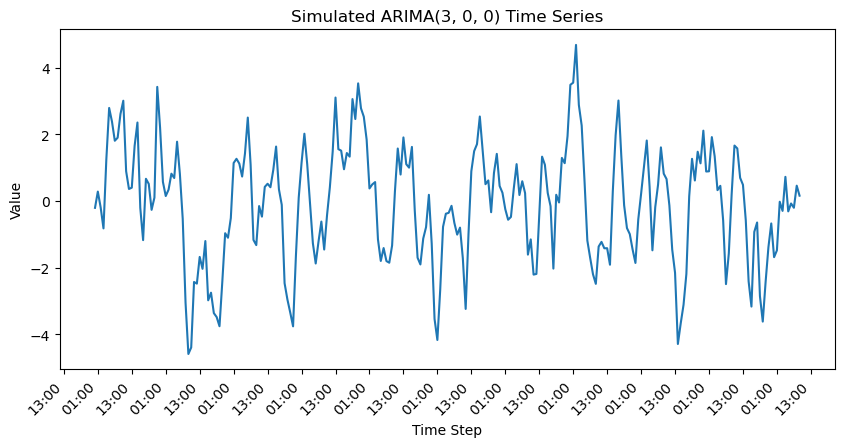

In [32]:
np.random.seed(12345)
arparams = np.array([0.95, -0.275, 0.025])
maparams = np.array([])
ar_params = np.r_[1, -arparams] # add zero-lag and negate
ma_params = np.r_[1, maparams] # add zero-lag

n_samples = 250

# Se puede genera una TS con
#y = arma_generate_sample(
#    ar=ar_params, 
#    ma=ma_params, 
#    nsample=n_samples, 
#    scale=1            # Standard deviation of the noise
#)
# o también
arma_process = ArmaProcess(ar_params, ma_params)
arma_sample = arma_process.generate_sample(n_samples, scale=1.0)


y = pd.Series(arma_sample, index=pd.date_range(start='2026-01-01 00:00:00', periods=n_samples, freq='1h'))

import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y)
# Use DateFormatter to show only the hour (%H)
hour_form = mdates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(hour_form)

# Optional: Adjust locator to place ticks at the start of each year (or at intervals)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))

# Optional: Improve label presentation (e.g., rotation)
fig.autofmt_xdate(rotation=45, ha='right')
ax.set_title("Simulated ARIMA(3, 0, 0) Time Series")
ax.set_xlabel("Time Step")
ax.set_ylabel("Value")

Realizamos la prueba de Dickey-Fuller aumentado para confirmar que la serie es estacionaria. La expresión para la serie con los coeficientes elegidos es

$$x_t = 0.95 x_{t-1} - 0.275 x_{t-2} + 0.025 x_{t-3} + w_t$$

cuyas raíces son 2, 4 y 5.

In [33]:
adf_test(y)

Results of Dickey-Fuller Test:
Test Statistic                -6.809353e+00
p-value                        2.135895e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


Representamos las funciones de autocorrelación parcial y autocorrelación parcial. por construcción, esperamos que la función de autocorrelación parcial no tenga valores distintos de cero con significancia estadística despué del lag 3. 

Text(0.5, 0, 'Lags')

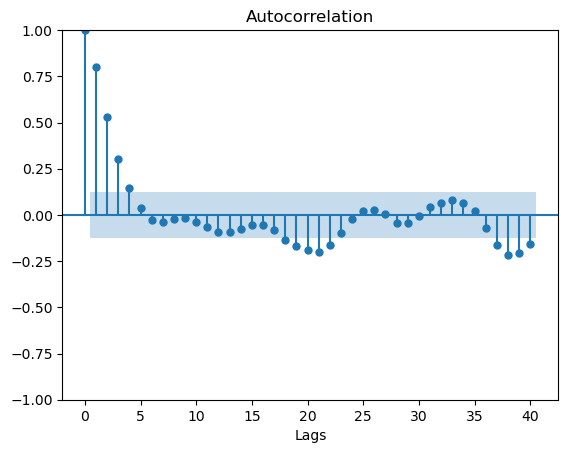

In [34]:
plot_acf(y, lags=40, bartlett_confint=False)
plt.xlabel('Lags')

Text(0.5, 0, 'Lags')

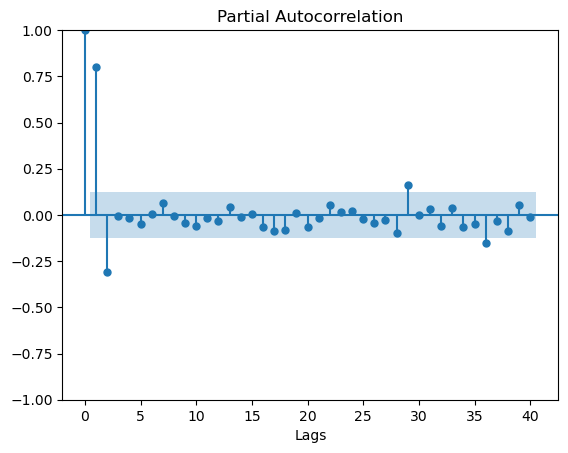

In [35]:
plot_pacf(y, lags=40)
plt.xlabel('Lags')

Ensayamos el ajuste al modelo esperado con la clase `ARIMA`. Notamos que a diferencia de ` sklearn`, luego de ajustar el modelo con el método `fit()`, obtenemos otra clase denominada `ARIMAResult` sobre la que extraeremos las predicciones y otras propiedades.

In [36]:
model = ARIMA(y, order=(3, 0, 0), trend='n')
res = model.fit()
print('Sumary: ', res.summary())
print('Params: ', model.params_complete)

Sumary:                                 SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -353.253
Date:                Tue, 03 Feb 2026   AIC                            714.506
Time:                        12:44:22   BIC                            728.592
Sample:                    01-01-2026   HQIC                           720.176
                         - 01-11-2026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0390      0.065     15.919      0.000       0.911       1.167
ar.L2         -0.2966      0.094     -3.165      0.002      -0.480      -0.113
ar.L3         -0.0073      0.067     -0.109

Por ejemplo, luego que se ha ajustado el modelo y obtenido sus parámetros se puede generar una TS sintética en base a esa configuración.

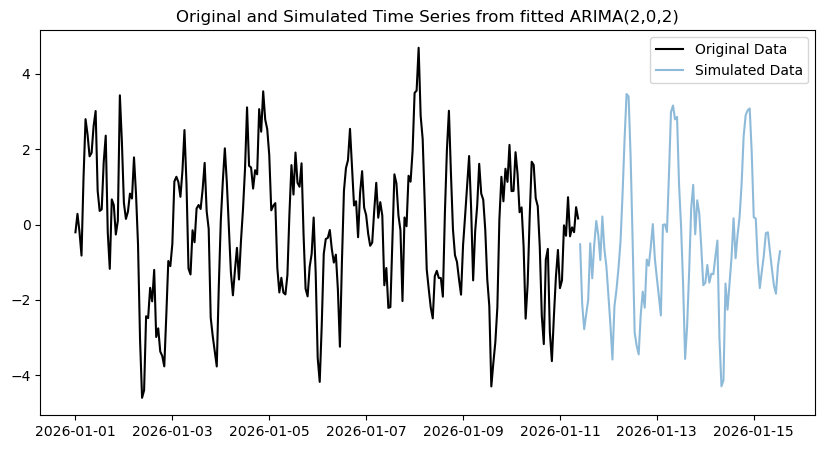

In [37]:
# Simulate data starting from the end of the original time series
# Simulate 100 new observations
n_simulations = 100
simulated_series = res.simulate(n_simulations, anchor='end')

# Plot original and simulated data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y,label='Original Data', color='k')
ax.plot(simulated_series, label='Simulated Data', color='C0', alpha=0.5)
ax.set_title("Original and Simulated Time Series from fitted ARIMA(2,0,2)")
plt.legend()


El método `predict()` nos da las prediciones en los pasos de tiempo cargados incialmenente en la definición del modelo `ARIMA` (no hace falta pasar la variable endógena como pensaríamos de `sklearn`. Asimismo, se puede pronosticar con el método `forecast(n)`  n-pasos delante. Ciertamente, al no coniderar el ruido, el pronóstico converge a la media del modelo. 

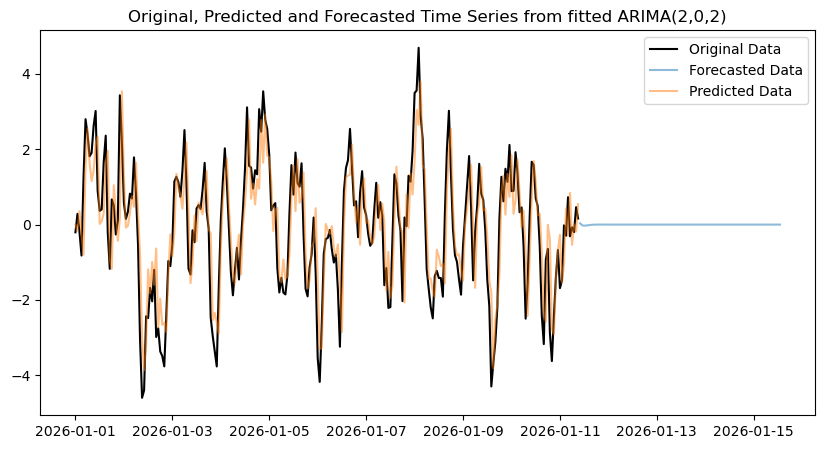

In [38]:
# Predicted values with fitted model
predicted_series = res.get_prediction().predicted_mean

# forecast data starting from the end of the original time series
# Forecast 100 new observations
n_forecasts = 100
forecasted_series = res.get_forecast(n_forecasts).predicted_mean

# Plot original and simulated data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y,label='Original Data', color='k')
ax.plot(forecasted_series, label='Forecasted Data', color='C0', alpha=0.5)
ax.plot(predicted_series, label='Predicted Data', color='C1', alpha=0.5)
ax.set_title("Original, Predicted and Forecasted Time Series from fitted ARIMA(2,0,2)")
plt.legend()

Si no conocemos el orden del modelo AR(p), para hallar el $p$ que logra el mejor ajuste utilizaremos el criterio de información de Akaike que busca maximizar el logaritmo de la verosimilitud (*likelihood*) pero penaliza la abundancia de parámetros 

AIC = -2 log-likelihood + 2 cantidad-de-parámetros

La verosimilitud medirá la probabilidad de observar un conjunto de datos dado un modelo con sus parámetros ajustados. Es decir, que la verosimilitud invierte la lógica. Dado un conjunto de datos observado, la verosimilitud estimará que tan probable es que diferentes parámetros del modelo generen la sequencia observada. Esta función puede pensarse como una respuesta a la pregunta de *"¿qué tan probable es que mis datos observados provengan de un dado modelo ARMA(p,q) propuesto?"*.

AIC mantiene un balance entre subajuste (*underfitting*) y sobreajuste (*overfitting*). Así, es una medida relativa entre diferentes modelos. no dice cuál es el modelo bueno sino cuál es el más adeucado entre los propuestos. 

A partir de estos argumentos, planteamos una iteración para valores crecientes de $p$ y nos quedaremos con aquel modelo que obtenga el menor AIC.

In [39]:
p_max = 6

aic_array = np.empty(p_max)
mse_array = np.empty(p_max)

for p in range(p_max):
    model = ARIMA(y, order=(p, 0, 0), trend='n')
    res = model.fit(method='yule_walker')
    aic_array[p] = res.aic
    mse_array[p] = res.mse
    if p == 0:
        aic_min = res.aic
        p_best = 0
    else:
        if aic_min > res.aic:
            aic_min = res.aic
            p_best = p

print(f'Best order: ({p_best}, 0, 0)')


Best order: (2, 0, 0)


Vemos que, si bien no se ha reobtenido el orden propuesto inicialmente, el criterio de Akaike nos deja un modelo similar. Buscar el mínimo del MSE no es suficiente ya que, al crecer el orden, siempre disminuyen los residuos. 

In [40]:
print(mse_array)

[3.01522203 1.08557517 0.98367306 0.98362009 0.98338307 0.98065812]


## Ayuda para el ejercicio 4

Analizar la serie histórica de niveles (alturas en metros) registrados en la estación hidrométrica Corrientes de la Red Hidrológica Nacional consultada desde [Sistema Nacional de Información Hídrica](https://snih.hidricosargentina.gob.ar/Filtros.aspx). En particular, nos quedaremos con los promedios anuales desde el año 1910. La estimación y pronóstico de alturas hidrométricas tiene mucho impacto ya que los niveles bajos limitan la navegación del Paraná y la toma de aguas, mientras que los altos afectan a las poblaciones ribereñas.

Comenzamos cargando la base de datos de alturas. Notamos que algunas fechas cuentan con varias lecturas por lo que forzamos a un valor medio diario.

In [41]:
corrientes = pd.read_excel('Data/niveles_Corrientes.xlsx', skiprows=1)
print('Nombre de las columnas:', corrientes.columns)

Nombre de las columnas: Index(['Fecha y Hora', 'Altura [m]'], dtype='object')


In [42]:
# Construímos la serie de alturas diarias
# coerce convierte a np.nan datos que no pueden ser transformados a float
# resample nos asegura que si hay más de un dato diario, se quedará con el promedio
# asfreq nos completa las fechas, eventualmente con np.nan si no hay dato
dti = pd.to_datetime(corrientes['Fecha y Hora'], format='%d/%m/%Y %H:%M')
niveles = pd.Series(pd.to_numeric(corrientes['Altura [m]'], errors='coerce', downcast='float').values, index=dti)
niveles_diarios = niveles.resample('1d', origin='1910-01-01').mean().asfreq('D')

In [43]:
print(niveles_diarios[0:5])

Fecha y Hora
1910-01-01    1.96
1910-01-02    2.02
1910-01-03    2.09
1910-01-04    2.20
1910-01-05    2.30
Freq: D, dtype: float32


In [44]:
# Chequeamos si hay muchos años con un faltante importante de datos
suma_nans = niveles_diarios.isna().resample('YE').sum().asfreq('YE')
suma_nans[suma_nans > 10]

Fecha y Hora
1911-12-31    59
2025-12-31    31
dtype: int64

Finalmente, nos interesa recuperar los promedios de altura anuales para estudiar si corresponden a un proceso estacionario autoregresivo y, eventualmente, ajustar un modelo AR(p).

In [45]:
# Nos quedamos con los promedios anuales
niveles_anuales = niveles_diarios.resample('YE').mean().asfreq('YE')
niveles_anuales.index.rename('Year', inplace=True)
niveles_anuales.rename('Altura [m]', inplace=True)

Year
1910-12-31    2.249534
1911-12-31    3.396536
1912-12-31    4.029508
1913-12-31    3.011890
1914-12-31    2.869945
                ...   
2021-12-31    1.387972
2022-12-31    2.075659
2023-12-31    3.527271
2024-12-31    2.151902
2025-12-31    2.140116
Freq: YE-DEC, Name: Altura [m], Length: 116, dtype: float32

Separamos en datos de entrenamiento y prueba. Realizamos un gráfico para ayudarnos a interpretar el proceso.

<Axes: xlabel='Year'>

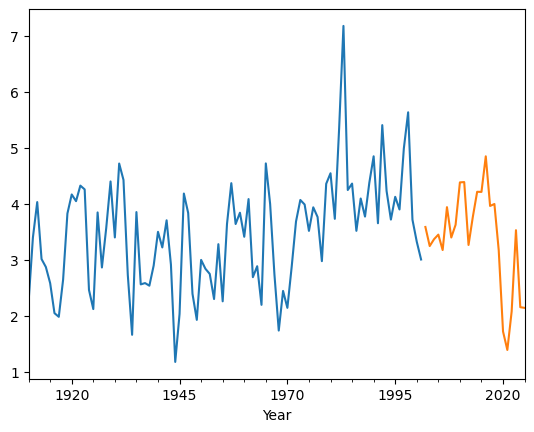

In [46]:
na_train = niveles_anuales[:int(0.8*niveles_anuales.size)]
na_test = niveles_anuales[int(0.8*niveles_anuales.size):]

na_train.plot(label='Train', c='C0')
na_test.plot(label='Test', c='C1')

Ahora representamos las funciones de autocorrelación y autocorrelación parcial.

Text(0.5, 0, 'Lags')

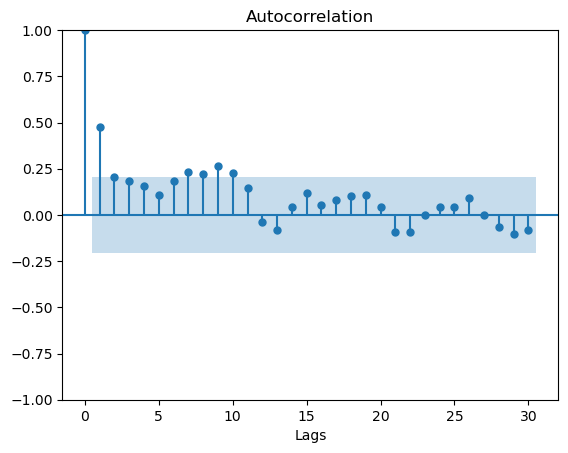

In [47]:
plot_acf(na_train, lags=30, bartlett_confint=False)
plt.xlabel('Lags')

Text(0.5, 0, 'Lags')

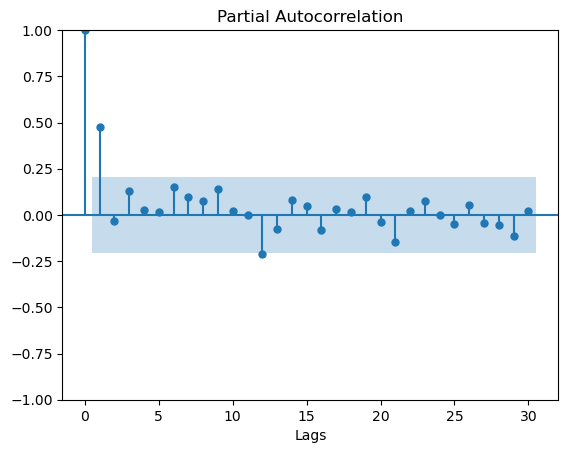

In [48]:
plot_pacf(na_train, lags=30)
plt.xlabel('Lags')

Observamos que la función de autocorrelación parcial registra un valor alto con significacnia estadística solo para el primer lag, sugiriendo un modelo AR(1).
A su vez, chequeamos que la serie de alturas sea estacionaria para poder avanzar con el modelo.

In [49]:
adf_test(na_train)

Results of Dickey-Fuller Test:
Test Statistic                -5.650698e+00
p-value                        9.876158e-07
#Lags Used                     0.000000e+00
Number of Observations Used    9.100000e+01
Critical Value (1%)           -3.504343e+00
Critical Value (5%)           -2.893866e+00
Critical Value (10%)          -2.584015e+00
dtype: float64


La serie es estacionaria... probamos si se puede ajustar con un modelo AR(p)

Vamos a iterar sobre distintos $p$ de manera de quedarnos con aquel modelo que logra el AIC más bajo.

In [50]:
p_max = 10
aic_array = np.empty(p_max)

for p in range(p_max):
    model = ARIMA(na_train, order=(p, 0, 0), trend='c')
    res = model.fit(method='yule_walker')
    aic_array[p] = res.aic
    if p == 0:
        aic_min = res.aic
        p_best = 0
    else:
        if aic_min > res.aic:
            aic_min = res.aic
            p_best = p

print(f'Best order: ({p_best}, 0, 0)')

Best order: (1, 0, 0)


Representamos la serie de alturas (promedio anual) de la estación hidrológica Corrientes y las comparamos con las predicciones del modelo AR(1) tanto con datos de entrenamiento como de prueba.

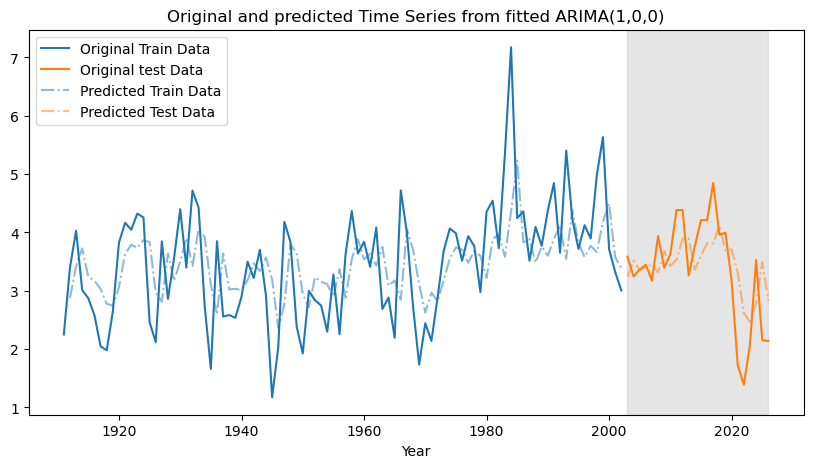

In [51]:
model = ARIMA(na_train, order=(p_best, 0, 0), trend='c')
res_train = model.fit(method='yule_walker')
# Predicted values with fitted model
train_predicted_series = res_train.get_prediction().predicted_mean[p_best:]

res_test = res_train.extend(na_test)
test_predicted_series = res_test.fittedvalues

# Plot original and simulated data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(na_train,label='Original Train Data', color='C0')
ax.plot(na_test,label='Original test Data', color='C1')
ax.plot(train_predicted_series, label='Predicted Train Data', color='C0', alpha=0.5, linestyle='-.')
ax.plot(test_predicted_series, label='Predicted Test Data', color='C1', alpha=0.5, linestyle='-.')
ax.axvspan(na_test.index[0],na_test.index[-1],color='#808080', alpha=0.2)
ax.set_title(f'Original and predicted Time Series from fitted ARIMA({p_best},0,0)')
ax.set_xlabel('Year')
plt.legend()

Finalmente, evaluamos el desempeño del modelo en entrenamiento y prueba, y lo comparamos con un modelo base que la predicción toma el valor registrado en el año inmediato anterior.

In [52]:
print(f'ARMA Model Train Data RMSE: {np.sqrt(res_train.mse):.3f}')
print(f'ARMA Model Test Data RMSE: {np.sqrt(res_test.mse):.3f}')

ARMA Model Train Data RMSE: 0.867
ARMA Model Test Data RMSE: 0.687


In [53]:
ly_train = na_train.shift(1)
ly_test = na_test.shift(1)
mse_train = np.mean((ly_train - ly_train.mean())**2)
mse_test = np.mean((ly_test - ly_test.mean())**2)

print(f'Last Year Model Train Data RMSE: {np.sqrt(mse_train):.3f}')
print(f'Last Year Test Data RMSE: {np.sqrt(mse_test):.3f}')

Last Year Model Train Data RMSE: 0.992
Last Year Test Data RMSE: 0.856


Para mayor confianza en la elección del orden del modelo, podemos explorar los residuos esperando que sean una realización de una variable aletoria independiente e identicamente distribuídas. Podemos tomar el resiudo directamente `res_train.resid` o usar `plot_diagnostic()` con la cual el paquete `stastmodel` nos facilita el análisis cualitativo.

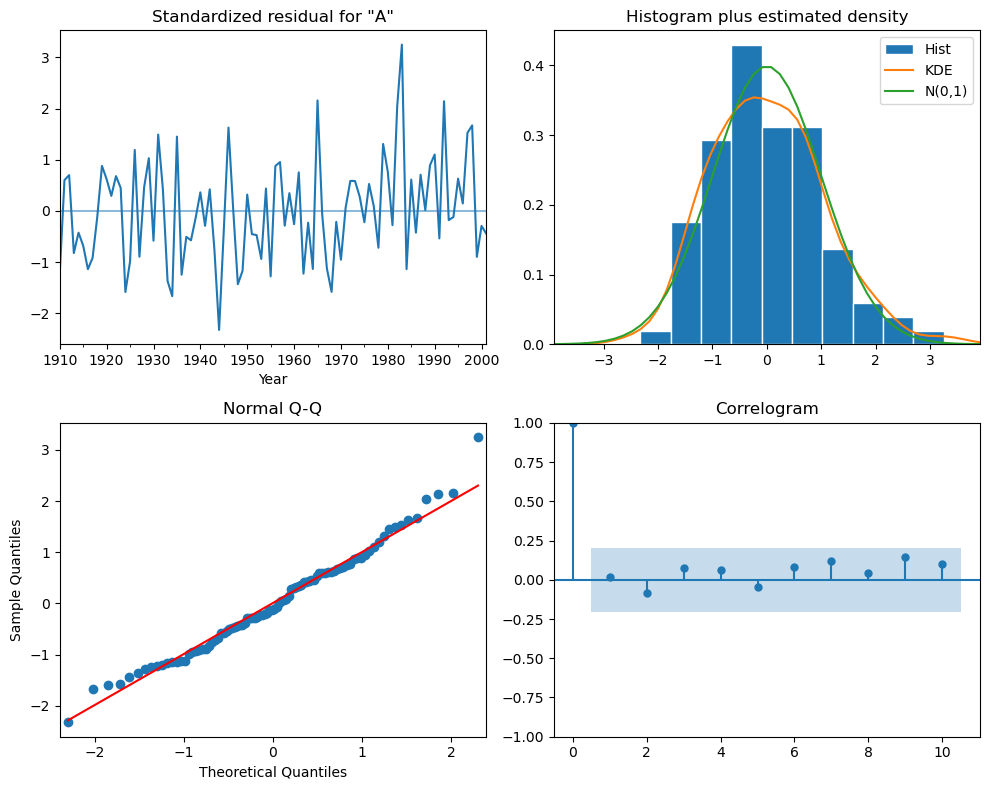

In [54]:
res_train.plot_diagnostics(figsize=(10,8))
plt.tight_layout()